Available input paths (first 10):
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r1148801et.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r09245347t.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r13907965t.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r09670876t.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r08788547t.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r18791531t.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r0773471dt.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r12946364t.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r077507cat.png
/kaggle/input/lol-v2-dataset/LOL-v2/Synthetic/Test/Low/r096982ddt.png
... and 4568 more files
Original LOL dataset found at /kaggle/input/loldataset/LOLdataset
LOL Dataset - Training samples loaded: 485
LOL Dataset - Validation samples loaded: 15
LOL-V2 dataset found at /kaggle/input/lol-v2-dataset/LOL-v2
LOL-V2 Real - Train Low: 689,

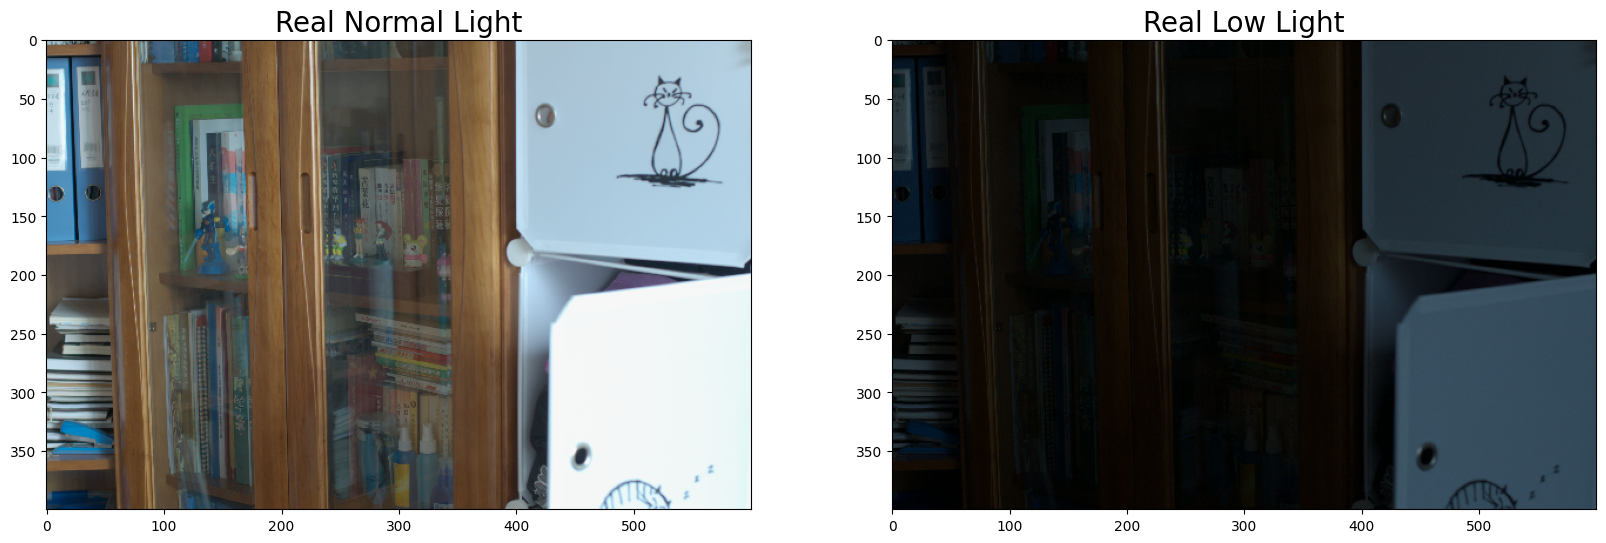

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import imageio.v2 as imageio

# Check Kaggle input paths
print("Available input paths (first 10):")
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= 10:
            break
    if count >= 10:
        break
print(f"... and {sum(len(f) for _, _, f in os.walk('/kaggle/input')) - 10} more files")

# Paths for original LOL and LOL-v2 datasets
lol_base = '/kaggle/input/loldataset/LOLdataset'
lolv2_base = '/kaggle/input/lol-v2-dataset/LOL-v2'

# helper function to load images from a directory
def load_images_from_folder(folder, max_files=None):
    images = []
    files = sorted(glob.glob(os.path.join(folder, "*.png")))
    if max_files:
        files = files[:max_files]
    for file in files:
        try:
            image = imageio.imread(file)
            images.append(image)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images)

# === ORIGINAL LOL DATASET ===
if os.path.exists(lol_base):
    print(f"Original LOL dataset found at {lol_base}")
    train_high_path = os.path.join(lol_base, 'train/high')
    train_low_path = os.path.join(lol_base, 'train/low')
    val_high_path = os.path.join(lol_base, 'val/high')
    val_low_path = os.path.join(lol_base, 'val/low')

    # Load training and validation images
    high_images = load_images_from_folder(train_high_path)
    low_images = load_images_from_folder(train_low_path)
    high_val = load_images_from_folder(val_high_path)
    low_val = load_images_from_folder(val_low_path)

    print(f"LOL Dataset - Training samples loaded: {len(high_images)}")
    print(f"LOL Dataset - Validation samples loaded: {len(high_val)}")
else:
    print("Original LOL dataset not found.")

# === LOL-V2 DATASET ===
if os.path.exists(lolv2_base):
    print(f"LOL-V2 dataset found at {lolv2_base}")

    def get_v2_paths(base_type='Real_captured', split='Train'):
        low_path = os.path.join(lolv2_base, base_type, split, 'Low')
        normal_path = os.path.join(lolv2_base, base_type, split, 'Normal')
        return low_path, normal_path

    # Load LOL-V2 Real_captured training data
    real_low_train_path, real_normal_train_path = get_v2_paths('Real_captured', 'Train')
    real_low_test_path, real_normal_test_path = get_v2_paths('Real_captured', 'Test')

    real_train_low = load_images_from_folder(real_low_train_path)
    real_train_normal = load_images_from_folder(real_normal_train_path)
    real_test_low = load_images_from_folder(real_low_test_path)
    real_test_normal = load_images_from_folder(real_normal_test_path)

    print(f"LOL-V2 Real - Train Low: {len(real_train_low)}, Normal: {len(real_train_normal)}")
    print(f"LOL-V2 Real - Test Low: {len(real_test_low)}, Normal: {len(real_test_normal)}")

    # Load LOL-V2 Synthetic training data
    syn_low_train_path, syn_normal_train_path = get_v2_paths('Synthetic', 'Train')
    syn_low_test_path, syn_normal_test_path = get_v2_paths('Synthetic', 'Test')

    syn_train_low = load_images_from_folder(syn_low_train_path)
    syn_train_normal = load_images_from_folder(syn_normal_train_path)
    syn_test_low = load_images_from_folder(syn_low_test_path)
    syn_test_normal = load_images_from_folder(syn_normal_test_path)

    print(f"LOL-V2 Synthetic - Train Low: {len(syn_train_low)}, Normal: {len(syn_train_normal)}")
    print(f"LOL-V2 Synthetic - Test Low: {len(syn_test_low)}, Normal: {len(syn_test_normal)}")
else:
    print("LOL-V2 dataset not found.")

# === Show sample image from LOL-V2 Real if available ===
if len(real_train_low) > 0 and len(real_train_normal) > 0:
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Real Normal Light", fontsize=20)
    plt.imshow(real_train_normal[0])

    plt.subplot(1, 2, 2)
    plt.title("Real Low Light", fontsize=20)
    plt.imshow(real_train_low[0])
    plt.savefig('lolv2_sample_comparison.png')
    plt.show()
else:
    print("No sample images available to display from LOL-V2 Real_captured.")


In [4]:
# Define PSNR metric for evaluation
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Data normalization function
def normalize_data(data):
    # Convert to float32 and normalize to [0,1]
    return data.astype('float32') / 255.0


In [5]:
# Normalize helper
def normalize_data(images):
    return images.astype(np.float32) / 255.0

# Prepare dataset containers
all_low_images = []
all_high_images = []

# === Original LOL ===
if len(low_images) > 0 and len(high_images) > 0:
    all_low_images.extend(low_images)
    all_high_images.extend(high_images)
    print(f"✔ LOL: {len(low_images)} pairs")

# === LOL-V2 Real_captured ===
if len(real_train_low) > 0 and len(real_train_normal) > 0:
    all_low_images.extend(real_train_low)
    all_high_images.extend(real_train_normal)
    print(f"✔ LOL-V2 Real: {len(real_train_low)} pairs")

# === LOL-V2 Synthetic ===
if len(syn_train_low) > 0 and len(syn_train_normal) > 0:
    all_low_images.extend(syn_train_low)
    all_high_images.extend(syn_train_normal)
    print(f"✔ LOL-V2 Synthetic: {len(syn_train_low)} pairs")

# Check
assert len(all_low_images) == len(all_high_images), "Mismatch in low/high image counts"

# Shuffle and normalize
combined = list(zip(all_low_images, all_high_images))
np.random.shuffle(combined)

all_low_images, all_high_images = zip(*combined)

# Normalize (keeping as lists of arrays with original sizes)
low_norm = [normalize_data(img) for img in all_low_images]
high_norm = [normalize_data(img) for img in all_high_images]

# Validation split (index-based)
val_split = 0.1
val_size = int(len(low_norm) * val_split)

val_indices = np.random.choice(len(low_norm), val_size, replace=False)
train_indices = list(set(range(len(low_norm))) - set(val_indices))

low_train_norm = [low_norm[i] for i in train_indices]
high_train_norm = [high_norm[i] for i in train_indices]
low_val_norm = [low_norm[i] for i in val_indices]
high_val_norm = [high_norm[i] for i in val_indices]

print("\nFinal dataset sizes:")
print("Train pairs:", len(low_train_norm))
print("Validation pairs:", len(low_val_norm))

# Show a few random shapes
print("\nSample input image shapes (mixed):")
for i in range(3):
    print(f"Sample {i+1}: Low shape = {low_train_norm[i].shape}, High shape = {high_train_norm[i].shape}")


✔ LOL: 485 pairs
✔ LOL-V2 Real: 689 pairs
✔ LOL-V2 Synthetic: 900 pairs

Final dataset sizes:
Train pairs: 1867
Validation pairs: 207

Sample input image shapes (mixed):
Sample 1: Low shape = (400, 600, 3), High shape = (400, 600, 3)
Sample 2: Low shape = (384, 384, 3), High shape = (384, 384, 3)
Sample 3: Low shape = (400, 600, 3), High shape = (400, 600, 3)


In [6]:
import tensorflow as tf

# ==== Augmentation logic applied on-the-fly ====
def augment_image_pair(low_img, normal_img):
    # Convert to float32 and normalize [0,1]
    low_img = tf.image.convert_image_dtype(low_img, tf.float32)
    normal_img = tf.image.convert_image_dtype(normal_img, tf.float32)

    # Stack for consistent transforms
    combined = tf.stack([low_img, normal_img], axis=0)

    # Random flip
    combined = tf.image.random_flip_left_right(combined)
    combined = tf.image.random_flip_up_down(combined)

    # Random rotation (0 to 3 * 90 degrees)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    combined = tf.image.rot90(combined, k)

    # Apply brightness and contrast to only low light input
    low_aug = tf.image.random_brightness(combined[0], max_delta=0.1)
    low_aug = tf.image.random_contrast(low_aug, lower=0.9, upper=1.1)
    normal_aug = combined[1]

    # Resize or pad/crop to standard shape
    low_aug = tf.image.resize_with_crop_or_pad(low_aug, 400, 400)
    normal_aug = tf.image.resize_with_crop_or_pad(normal_aug, 400, 400)

    return low_aug, normal_aug

# Wrapper to use in map()
def tf_augment(low_img, normal_img):
    return augment_image_pair(low_img, normal_img)

# ==== Dataset creation function ====
def make_tf_dataset(low_list, high_list, batch_size=8, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((low_list, high_list))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(low_list), reshuffle_each_iteration=True)

    if augment:
        dataset = dataset.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# === Combine all images into lists ===
all_low_images = list(low_images) + list(real_train_low) + list(syn_train_low)
all_high_images = list(high_images) + list(real_train_normal) + list(syn_train_normal)

# === Sanity check ===
assert len(all_low_images) == len(all_high_images), "Mismatch in low/high image counts"

# === Normalize ===
def normalize_data(img_list):
    return [img.astype(np.float32) / 255.0 for img in img_list]

all_low_images = normalize_data(all_low_images)
all_high_images = normalize_data(all_high_images)

# === Train/Val split (index-based, since we’re working with lists of arrays) ===
indices = np.arange(len(all_low_images))
np.random.shuffle(indices)

split = int(len(indices) * 0.9)
train_idx, val_idx = indices[:split], indices[split:]

low_train_norm = [all_low_images[i] for i in train_idx]
high_train_norm = [all_high_images[i] for i in train_idx]
low_val_norm = [all_low_images[i] for i in val_idx]
high_val_norm = [all_high_images[i] for i in val_idx]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 384, 384, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 384, 384, 48)   │          1,344 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 384, 384, 48)   │            192 │ conv2d_56[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43             │ (None, 384, 384, 48)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 384, 384, 48)   │         20,784 │ activation_43[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 384, 384, 48)   │            192 │ conv2d_57[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_44             │ (None, 384, 384, 48)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 192, 192, 48)   │              0 │ activation_44[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 192, 192, 96)   │         41,568 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 192, 192, 96)   │            384 │ conv2d_58[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 192, 192, 96)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 192, 192, 96)   │         83,040 │ activation_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 192, 192, 96)   │            384 │ conv2d_59[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 96)             │              0 │ batch_normalization_2… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_

 Total params: 33,337,462 (127.17 MB)

 Trainable params: 33,323,254 (127.12 MB)

 Non-trainable params: 14,208 (55.50 KB)

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 0.2123 - psnr_metric: 15.4179 - ssim_metric: 0.6725
Epoch 1: val_psnr_metric improved from -inf to 17.60058, saving model to best_low_light_model.keras
466/466 ━━━━━━━━━━━━━━━━━━━━ 273s 408ms/step - loss: 0.2123 - psnr_metric: 15.4192 - ssim_metric: 0.6725 - val_loss: 0.1611 - val_psnr_metric: 17.6006 - val_ssim_metric: 0.7474 - learning_rate: 0.0010
Epoch 2/80
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - loss: 0.1838 - psnr_metric: 17.0601 - ssim_metric: 0.7121
Epoch 2: val_psnr_metric improved from 17.60058 to 18.80126, saving model to best_low_light_model.keras
466/466 ━━━━━━━━━━━━━━━━━━━━ 182s 390ms/step - loss: 0.1838 - psnr_metric: 17.0600 - ssim_metric: 0.7121 - val_loss: 0.1404 - val_psnr_metric: 18.8013 - val_ssim_metric: 0.7789 - learning_rate: 0.0010
Epoch 3/80
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.1750 - psnr_metric: 17.2862 - ssim_metric: 0.7262
Epoch 3: val_psnr_metric improved from 18.80126 to 19.34922, sa

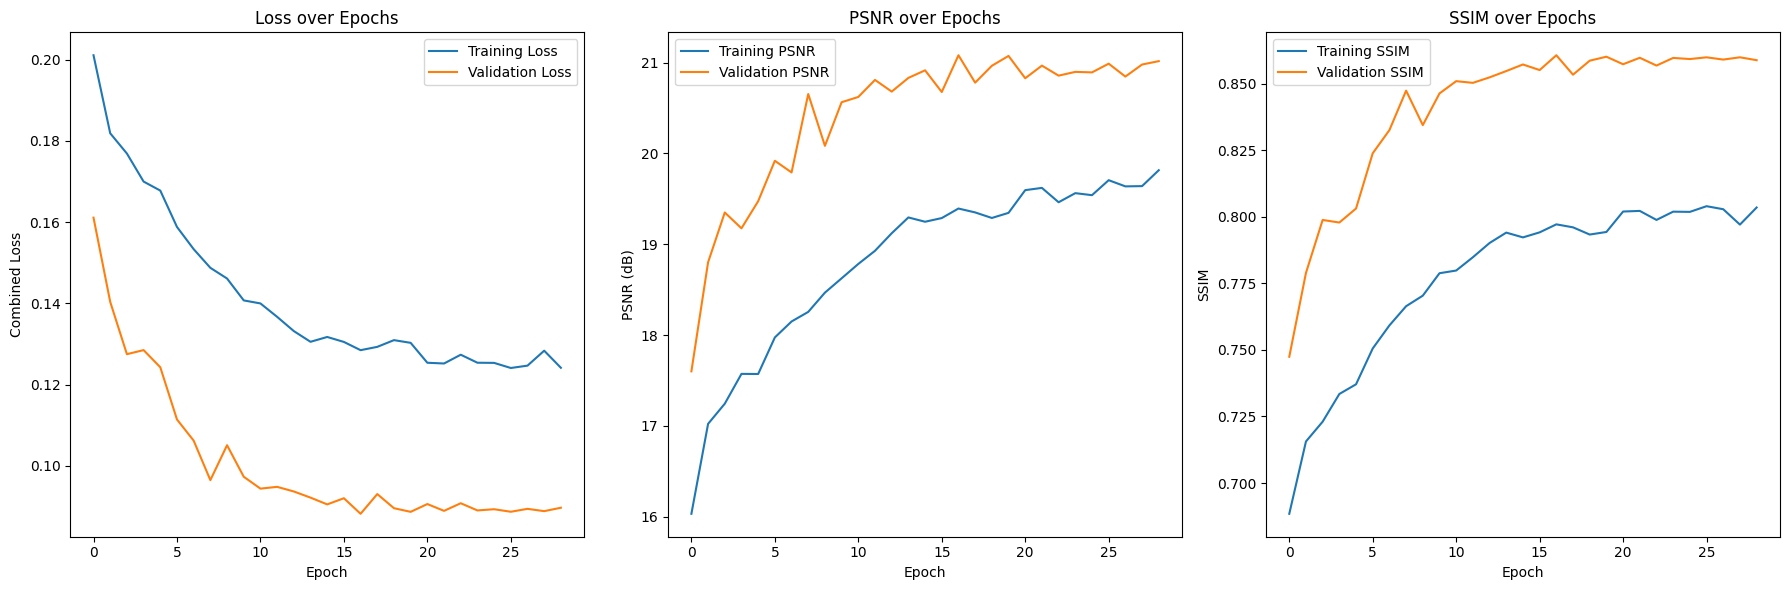

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# === Advanced Data Generator with Improved Augmentations (without TF Addons) ===
class EnhancedImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=4, target_size=(384, 384), augment=False, dataset_weights=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
        # Optional weights to balance between original LOL and LOL-v2
        self.dataset_weights = dataset_weights
        
    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, idx):
        X_batch = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        y_batch = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]

        X_out, y_out = [], []
        for x, y in zip(X_batch, y_batch):
            x = tf.convert_to_tensor(x, dtype=tf.float32)
            y = tf.convert_to_tensor(y, dtype=tf.float32)

            # Center crop then resize for better quality
            x = tf.image.resize(x, self.target_size, method='bicubic')
            y = tf.image.resize(y, self.target_size, method='bicubic')

            if self.augment:
                # More aggressive augmentation
                if tf.random.uniform(()) > 0.5:
                    x = tf.image.flip_left_right(x)
                    y = tf.image.flip_left_right(y)
                if tf.random.uniform(()) > 0.5:
                    x = tf.image.flip_up_down(x)
                    y = tf.image.flip_up_down(y)
                
                # Color augmentation only for input images
                if tf.random.uniform(()) > 0.5:
                    x = tf.image.random_brightness(x, max_delta=0.2)
                if tf.random.uniform(()) > 0.5:
                    x = tf.image.random_contrast(x, lower=0.8, upper=1.2)
                if tf.random.uniform(()) > 0.7:
                    x = tf.image.random_saturation(x, lower=0.8, upper=1.2)
                if tf.random.uniform(()) > 0.7:
                    x = tf.image.random_hue(x, max_delta=0.05)
                
                # Keep values in valid range
                x = tf.clip_by_value(x, 0.0, 1.0)

            X_out.append(x)
            y_out.append(y)

        return tf.stack(X_out), tf.stack(y_out)

# === Channel Attention Module ===
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    # Shared MLP
    shared_layer_one = layers.Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    
    # Global average pooling
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    # Global max pooling
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    # Merge the features and sigmoid activation
    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    
    # Multiply with input feature
    return layers.Multiply()([input_feature, cbam_feature])

# === Spatial Attention Module ===
def spatial_attention(input_feature):
    # Generate avg and max pooled features across channels
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    
    # Concatenate the features
    concat = layers.Concatenate()([avg_pool, max_pool])
    
    # Apply convolution and activation
    cbam_feature = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    
    # Multiply with input feature
    return layers.Multiply()([input_feature, cbam_feature])

# === Improved Attention Gate for Spatial Context ===
def attention_gate(x, gating, inter_channels):
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(gating)
    
    # Upsample gating signal if needed to match x dimensions
    if theta_x.shape[1] != phi_g.shape[1] or theta_x.shape[2] != phi_g.shape[2]:
        phi_g = layers.UpSampling2D(size=(theta_x.shape[1] // phi_g.shape[1], 
                                          theta_x.shape[2] // phi_g.shape[2]))(phi_g)
    
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(relu)
    sigmoid = layers.Activation('sigmoid')(psi)
    
    # Apply both spatial and channel attention
    attn_out = layers.Multiply()([x, sigmoid])
    return attn_out

# === Residual Block with CBAM (Convolutional Block Attention Module) ===
def residual_block(input_tensor, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add CBAM attention
    x = channel_attention(x)
    x = spatial_attention(x)
    
    # Skip connection
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, 1, padding='same')(input_tensor)
    
    x = layers.Add()([x, input_tensor])
    x = layers.Activation('relu')(x)
    
    return x

# === Enhanced U-Net with Multi-level Attention and Residual Blocks ===
def build_enhanced_unet(input_shape=(384, 384, 3), num_filters=48):
    inputs = keras.Input(shape=input_shape)
    
    # Initial feature extraction
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    conv1 = x
    
    # Encoder Path with Residual Blocks
    pool1 = layers.MaxPooling2D(2)(conv1)
    x = residual_block(pool1, num_filters*2)
    conv2 = x
    
    pool2 = layers.MaxPooling2D(2)(conv2)
    x = residual_block(pool2, num_filters*4)
    x = residual_block(x, num_filters*4)
    conv3 = x
    
    pool3 = layers.MaxPooling2D(2)(conv3)
    x = residual_block(pool3, num_filters*8)
    x = residual_block(x, num_filters*8)
    conv4 = x
    
    pool4 = layers.MaxPooling2D(2)(conv4)
    x = residual_block(pool4, num_filters*16)
    x = residual_block(x, num_filters*16)
    bottle = x
    
    # Decoder Path with Enhanced Attention
    up4 = layers.UpSampling2D(2)(bottle)
    attn4 = attention_gate(conv4, up4, num_filters*4)
    concat4 = layers.Concatenate()([up4, attn4])
    x = residual_block(concat4, num_filters*8)
    deconv4 = x
    
    up3 = layers.UpSampling2D(2)(deconv4)
    attn3 = attention_gate(conv3, up3, num_filters*2)
    concat3 = layers.Concatenate()([up3, attn3])
    x = residual_block(concat3, num_filters*4)
    deconv3 = x
    
    up2 = layers.UpSampling2D(2)(deconv3)
    attn2 = attention_gate(conv2, up2, num_filters)
    concat2 = layers.Concatenate()([up2, attn2])
    x = residual_block(concat2, num_filters*2)
    deconv2 = x
    
    up1 = layers.UpSampling2D(2)(deconv2)
    attn1 = attention_gate(conv1, up1, num_filters//2)
    concat1 = layers.Concatenate()([up1, attn1])
    x = residual_block(concat1, num_filters)
    deconv1 = x
    
    # Final output with residual connection from input
    output_conv = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(deconv1)
    
    # Global residual learning (helps with preserving details)
    outputs = layers.Add()([output_conv, inputs])
    outputs = layers.Lambda(lambda x: tf.clip_by_value(x, 0, 1))(outputs)
    
    model = keras.Model(inputs, outputs)
    return model

# === SSIM Loss - Better for perceptual quality ===
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# === Combined Loss Function ===
def combined_loss(y_true, y_pred):
    # MSE for pixel-level accuracy
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # SSIM for structural similarity
    ssim = ssim_loss(y_true, y_pred)
    # Combined loss with weighting
    return 0.4 * mse + 0.6 * ssim

# === PSNR Metric ===
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# === SSIM Metric ===
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# === Learning Rate Scheduler ===
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 15:
        return lr * 0.8
    elif epoch % 8 == 0:
        return lr * 0.8
    else:
        return lr

# === Instantiate the Enhanced Model ===
model = build_enhanced_unet(input_shape=(384, 384, 3), num_filters=48)

# Compile with combined loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[psnr_metric, ssim_metric]
)
model.summary()

# === Create Enhanced Generators ===
# low_train_norm, high_train_norm, low_val_norm, high_val_norm are the normalized data arrays
training_generator = EnhancedImageGenerator(
    low_train_norm, high_train_norm, 
    batch_size=4, 
    augment=True
)

validation_generator = EnhancedImageGenerator(
    low_val_norm, high_val_norm, 
    batch_size=4, 
    augment=False
)

# === Callbacks ===
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.ModelCheckpoint(
        'best_low_light_model.keras',
        monitor='val_psnr_metric',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_psnr_metric',
        mode='max',
        patience=12,
        restore_best_weights=True,
        verbose=1
    )
]

# === Train the Model ===
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=80,  # More epochs with early stopping
    callbacks=callbacks,
    verbose=1
)

# === Plot Training History ===
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Combined Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
plt.title('PSNR over Epochs')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
plt.title('SSIM over Epochs')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()

plt.tight_layout()
plt.savefig('enhanced_training_history.png')
plt.show()

# === Visualize Some Results ===
def visualize_results(model, low_images, high_images, num_samples=3):
    plt.figure(figsize=(15, 5*num_samples))
    
    # Randomly select samples
    indices = np.random.randint(0, len(low_images), num_samples)
    
    for i, idx in enumerate(indices):
        # Get images
        low_img = low_images[idx]
        high_img = high_images[idx]
        
        # Ensure 4D tensor for prediction
        low_tensor = tf.expand_dims(low_img, 0)
        
        # Predict enhanced image
        pred_img = model.predict(low_tensor)[0]
        
        # Display images
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(low_img)
        plt.title(f'Low Light Input')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(pred_img)
        plt.title(f'Model Output (PSNR: {psnr_metric(high_img[np.newaxis,...], pred_img[np.newaxis,...]).numpy():.2f}dB)')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(high_img)
        plt.title('Ground Truth')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('result_comparison.png')
    plt.show()


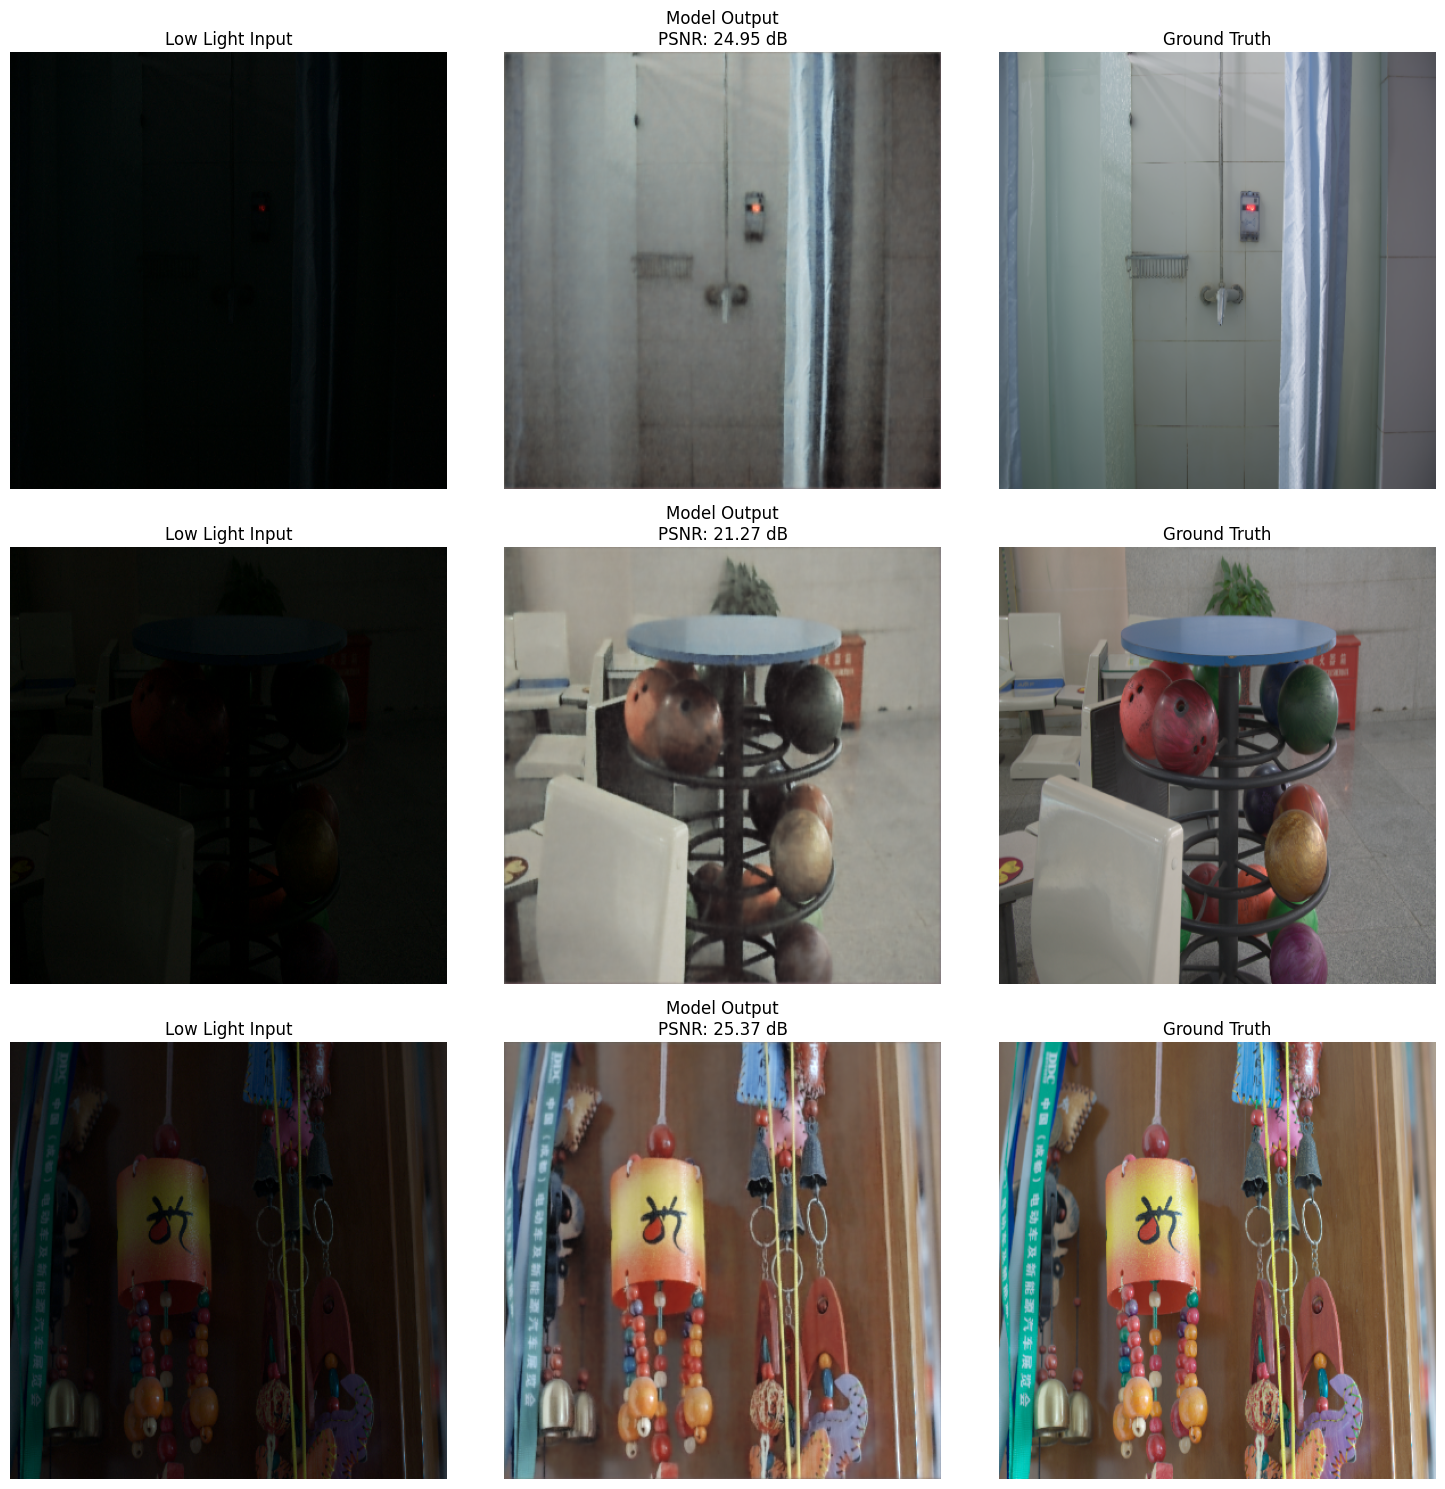

In [24]:
visualize_results(model, low_val_norm, high_val_norm, num_samples=3)


In [28]:
model.save('/kaggle/working/denoisinsg_model.keras')
